In [1]:
import pennylane as qml
import pennylane.numpy as np
from model import Model

In [2]:
name = 'phong_20_100'
def func(n, phi):
    return np.cos(phi) ** n
consts = {'ks': 0.5}
scalars = {'n': {'range':(20,100), 'type': np.uint32}}
angles = {'phi': {'range':(0, np.pi / 2)}}

In [3]:
model = Model(name)
model.set_function(func)
# model.set_consts(consts)
model.set_scalars(scalars)
model.set_angles(angles)

model.set_sample_size(1000)

while True:

	try:
		model.read_samples('samples/' + model.name + '.bin')
	except FileNotFoundError:
		# temp_scalars = {'n': {'range':(20,50), 'type': np.uint32}}
		# model.set_scalars(temp_scalars)
		model.generate_samples()
		# model.set_scalars(scalars)
		model.read_samples('samples/' + model.name + '.bin')

	model.dataset = list(filter(lambda x: (x[0] > 20 and x[0] < 30) or (x[0] > 50 and x[0] < 60) or (x[0] > 70 and x[0] < 80) or (x[0] > 90 and x[0] < 100)  , model.dataset))

	model.set_sample_size(500)
	if len(model.dataset) >= 500:
		model.dataset = model.dataset[:500]
		break
	
model.separate()

(<Figure size 17900x300 with 1 Axes>, <Axes: >)

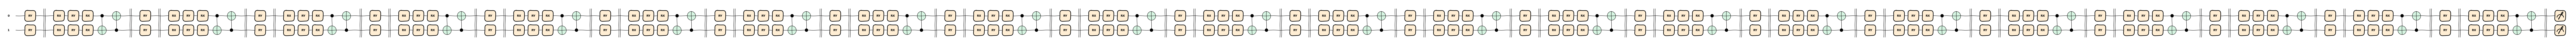

In [4]:
n_qubits = 2
layers = 22

model.generate_device(n_qubits)

def embedding(data, n_qubits, params):
	for i in range(n_qubits):
		if i < len(model.scalars):
			value = data[i]
			name = model.header[i + len(model.consts)]
			(min, max) = model.scalars.get(name).get('range')
			if min == max:
				value = value / max * np.pi / 2
			else:
				value = (value - min) / (max - min) * np.pi
			qml.RY(params[i] * value, wires=i)
		else:
			qml.RY(params[i] * data[i], wires=i)

	qml.Barrier()

def rot_ent(params, n_qubits):
	if len(params) < n_qubits * 3:
		raise ValueError('Not enough params')

	for i in range(n_qubits):
		qml.RX(params[i * n_qubits], wires=i)
		qml.RY(params[i * n_qubits + 1], wires=i)
		qml.RX(params[i * n_qubits + 2], wires=i)

	for i in range(n_qubits):
		qml.CNOT(wires=[i, (i + 1) % n_qubits])

	qml.Barrier()

def circuit(data, params):
	for i in range(layers):
		temp_params = params[i * n_qubits * 4 : (i + 1) * n_qubits * 4]
		embedding(data, n_qubits, temp_params[:n_qubits])

		rot_ent(temp_params[n_qubits:], n_qubits)

	return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1))

def _model(circ, input, params):
	return (circ(input, params) + 1) / 2

model.set_model(_model)
model.set_circuit(circuit)
model.generate_params((n_qubits * 4 * layers,))

qml.draw_mpl(model.circuit, style='sketch')(model.train_in, model.params)

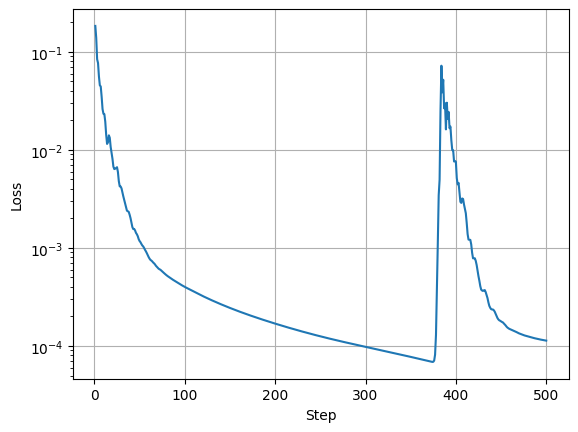

Loss: 0.00011339904306657547
Step 500
Estimated time remaining: 00:00:00:000


In [5]:
model.set_max_steps(500)
model.set_objective(1E-6)
model.optimization(objective=True, callback= 'graph')

In [6]:
print('Test score:', model.test())

Test score: 0.00035835819090033794


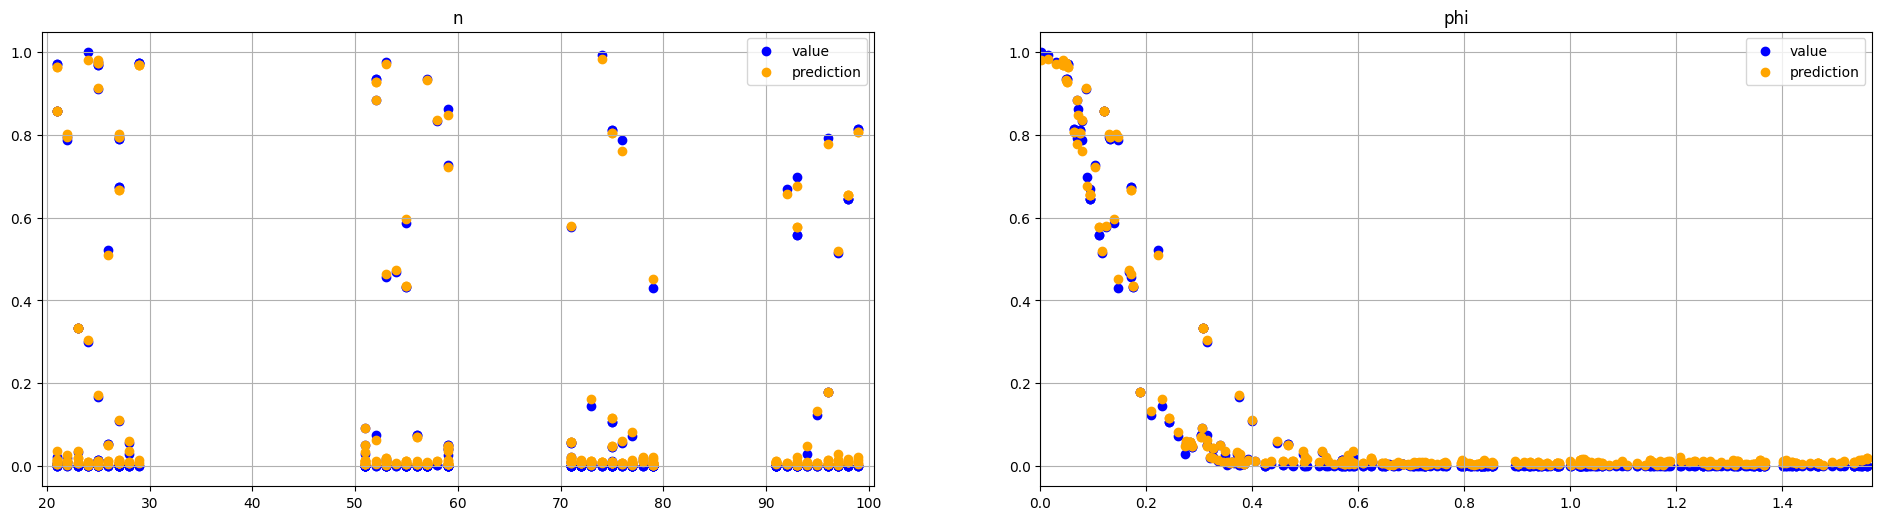

In [7]:
model.draw_train()

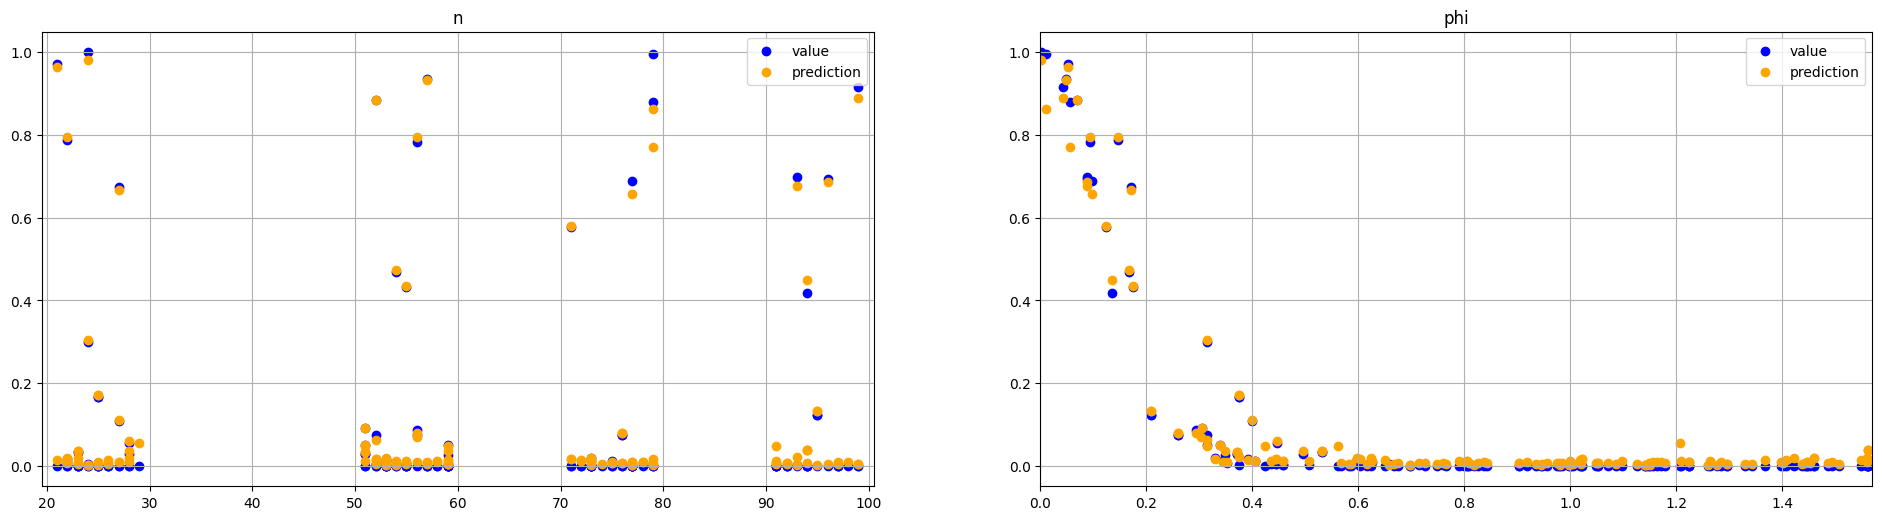

In [8]:
model.draw()

In [9]:
model.serialize('models/' + model.name + '_multi' + '.json', samples=True)

/tmp/ipykernel_1750/2941274134.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


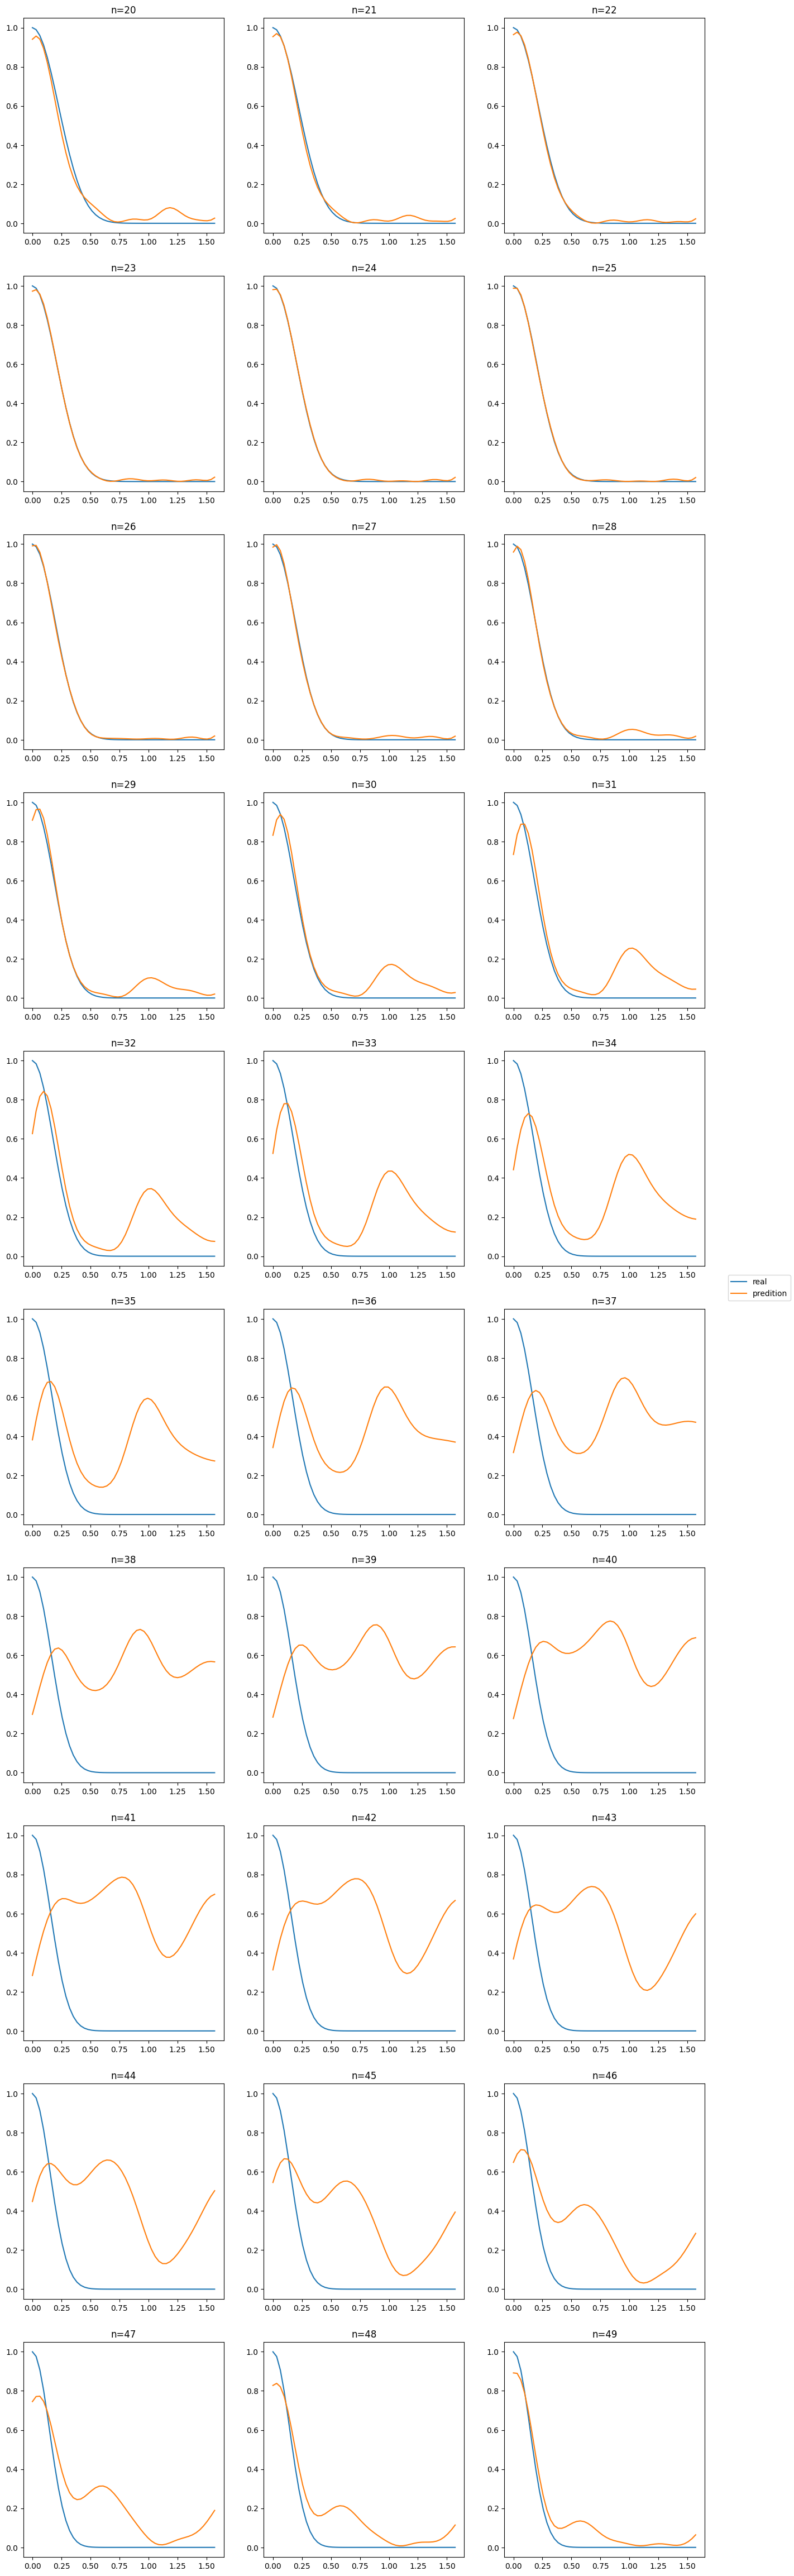

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(
	figsize=(40 * 1/2.54, 15 * 10 * 1/2.54),
)

axs = [fig.add_subplot(10,3, i) for i in range(1, 31)]


for n, ax in enumerate(axs):
	n = n + 20
	x = np.linspace(0, np.pi/2)
	y = list(map(lambda x: func(n, x), x))
	yy = list(map(lambda x:model.model(model.circuit,[n, x],model.params), x))
	ax.plot(x,y, label= 'Real')
	ax.plot(x,yy, label= 'Prediction')
	ax.set_title(f'n={n}')

fig.legend(['real','predition'],loc='center right')

fig.show()

/tmp/ipykernel_1750/1722258001.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


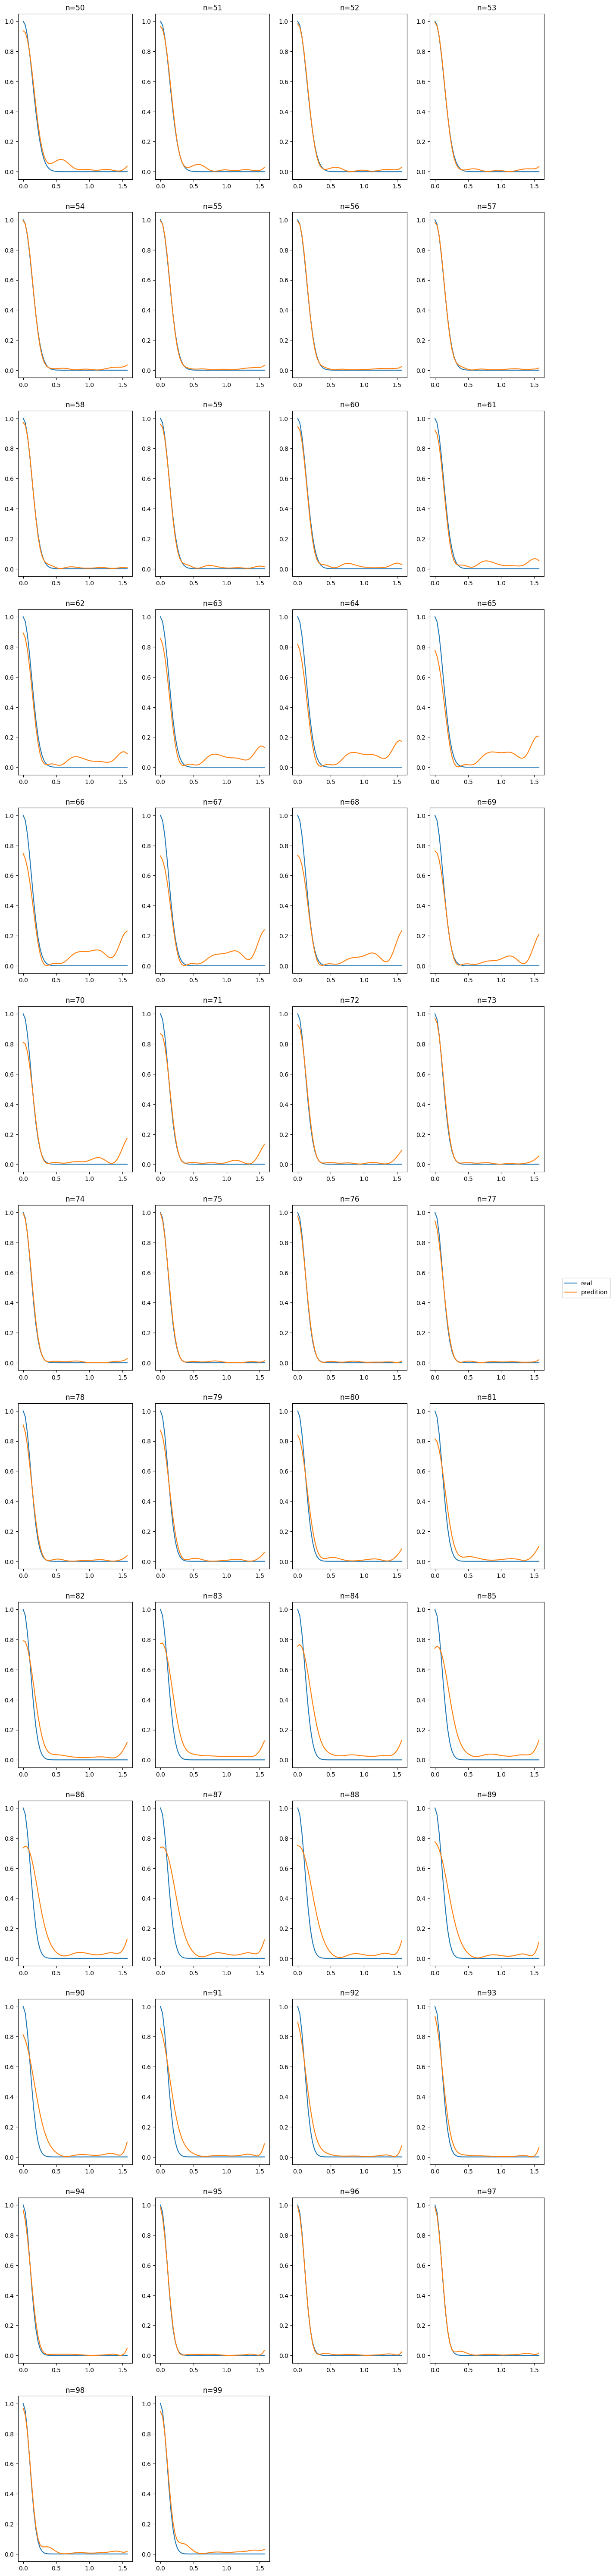

In [11]:
fig = plt.figure(
	figsize=(40 * 1/2.54, 15 * 13 * 1/2.54),
)

axs = [fig.add_subplot(13,4, i) for i in range(1, 51)]


for n, ax in enumerate(axs):
	n = n + 50
	x = np.linspace(0, np.pi/2)
	y = list(map(lambda x: func(n, x), x))
	yy = list(map(lambda x:model.model(model.circuit,[n, x],model.params), x))
	ax.plot(x,y, label= 'Real')
	ax.plot(x,yy, label= 'Prediction')
	ax.set_title(f'n={n}')

fig.legend(['real','predition'],loc='center right')

fig.show()